In [1]:
!pip install surprise matplotlib pandas seaborn joblib matplotlib



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Cell 1: Hàm trích xuất năm từ tiêu đề phim
import re

def extract_year(title):
    match = re.search(r'\b(\d{4})\b', title)  # Tìm năm 4 chữ số
    return int(match.group(0)) if match else None


In [3]:
# Cell 2: Nhập thư viện và dữ liệu
import pandas as pd
from data_preparation import ratings_df, movies_df, tags_df, users_df
from IPython.display import display

# Tùy chỉnh pandas để hiển thị đầy đủ các cột
pd.set_option('display.max_columns', None)

# Hiển thị dữ liệu dưới dạng bảng
display(movies_df)
display(ratings_df)
display(tags_df)
display(users_df)


   MovieID                               Title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                         Genre  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   UserID  MovieID  Rating           Timestamp
0       1        1     4.0 2000-07-30 18:45:03
1       1        3     4.0 2000-07-30 18:20:47
2       1        6     4.0 2000-07-30 18:37:04
3       1       47     5.0 2000-07-30 19:03:35
4       1       50     5.0 2000-07-30 18:48:51
   UserID UserName
0       1    User1
1       2    User2
2       3    User3
3       4    User4
4       5    User5
   UserID

,MovieID,Title,Genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


,UserID,MovieID,Rating,Timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51
...,...,...,...,...
100831,610,166534,4.0,2017-05-03 21:53:22
100832,610,168248,5.0,2017-05-03 22:21:31
100833,610,168250,5.0,2017-05-08 19:50:47
100834,610,168252,5.0,2017-05-03 21:19:12


,UserID,MovieID,Tag,Timestamp
0,2,60756,funny,2015-10-24 19:29:54
1,2,60756,Highly quotable,2015-10-24 19:29:56
2,2,60756,will ferrell,2015-10-24 19:29:52
3,2,89774,Boxing story,2015-10-24 19:33:27
4,2,89774,MMA,2015-10-24 19:33:20
...,...,...,...,...
3678,606,7382,for katie,2007-02-11 22:46:59
3679,606,7936,austere,2007-03-08 22:18:54
3680,610,3265,gun fu,2017-05-03 20:39:44
3681,610,3265,heroic bloodshed,2017-05-03 20:39:38


,UserID,UserName
0,1,User1
1,2,User2
2,3,User3
3,4,User4
4,5,User5
...,...,...
605,606,User606
606,607,User607
607,608,User608
608,609,User609


In [5]:
# Cell 3: Huấn luyện mô hình SVD
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import joblib
import numpy as np

def train_model():
    # Tạo Reader để định nghĩa định dạng dữ liệu
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(ratings_df[['UserID', 'MovieID', 'Rating']], reader)
    trainset, testset = train_test_split(data, test_size=0.25)

    # Huấn luyện mô hình
    svd_model = SVD()
    svd_model.fit(trainset)

    # Dự đoán và đánh giá mô hình
    predictions = svd_model.test(testset)

    # Tính RMSE và MAE
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)

    # Chuyển đổi dự đoán và thực tế thành dạng phù hợp để tính toán ma trận nhầm lẫn
    true_ratings = [int(round(pred.r_ui)) for pred in predictions]
    predicted_ratings = [int(round(pred.est)) for pred in predictions]

    # Tính toán ma trận nhầm lẫn và độ chính xác
    conf_matrix = confusion_matrix(true_ratings, predicted_ratings, labels=[1, 2, 3, 4, 5])
    accuracy_val = accuracy_score(true_ratings, predicted_ratings)

    # Lưu mô hình đã huấn luyện
    joblib.dump(svd_model, 'svd_model.pkl')

    return svd_model, rmse, mae, accuracy_val, conf_matrix

# Huấn luyện mô hình
svd_model, rmse, mae, accuracy_val, conf_matrix = train_model()

# In thông tin
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")
print(f"Accuracy: {accuracy_val:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


RMSE: 0.8784
MAE:  0.6743
RMSE: 0.8784, MAE: 0.6743
Accuracy: 0.4526
Confusion Matrix:
[[   2  144  393  127    5]
 [   3  541 2410  721   10]
 [   0  246 3039 1721   39]
 [   1  150 4202 7387  347]
 [   0   15  488 2419  440]]


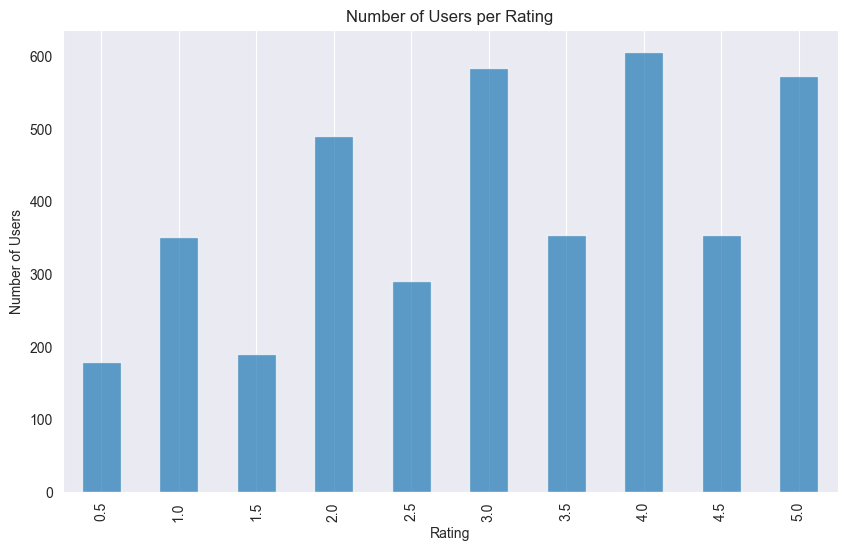

In [6]:
# Cell 4: Vẽ biểu đồ phân phối đánh giá
import matplotlib.pyplot as plt

def plot_rating_distribution():
    rating_user_counts = ratings_df.groupby('Rating')['UserID'].nunique()  # Số lượng người dùng đánh giá theo từng bậc
    plt.figure(figsize=(10, 6))
    rating_user_counts.plot(kind='bar', alpha=0.7)
    plt.xlabel('Rating')
    plt.ylabel('Number of Users')
    plt.title('Number of Users per Rating')
    plt.grid(axis='y')
    plt.show()  # Hiển thị biểu đồ trên Jupyter Notebook

# Vẽ biểu đồ phân phối đánh giá
plot_rating_distribution()


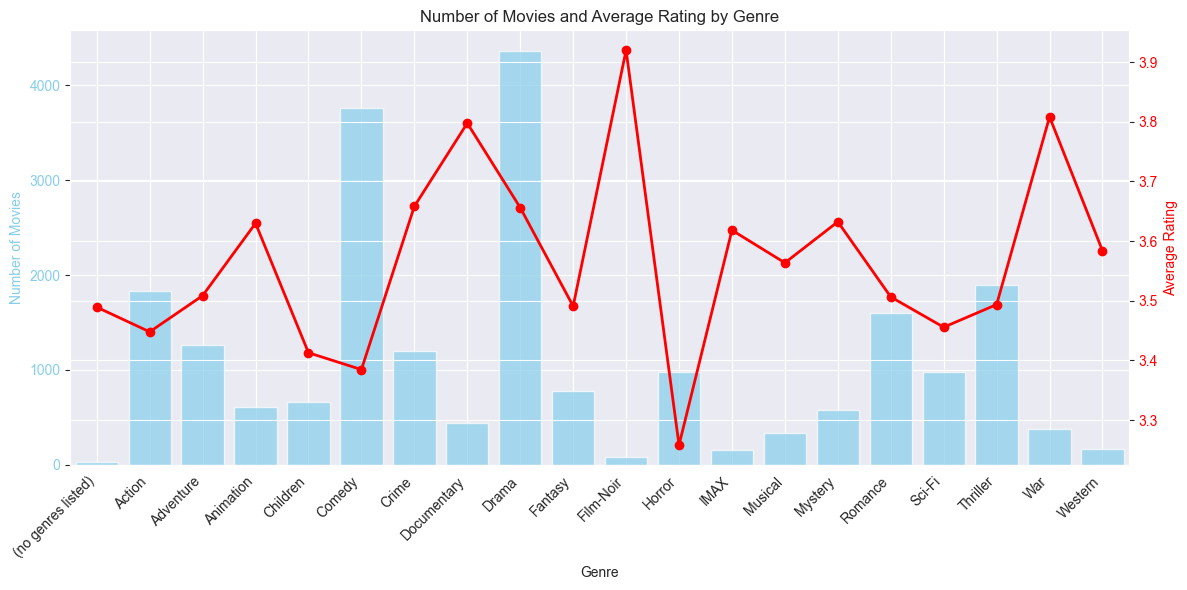

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Tách các thể loại phim
genres_df = movies_df.copy()
genres_df['Genre'] = genres_df['Genre'].str.split('|')

# Tách và đếm số lượng phim theo từng thể loại
genres_exploded = genres_df.explode('Genre')

# Kết hợp dữ liệu movies_df với ratings_df để tính rating trung bình
merged_df = pd.merge(genres_exploded, ratings_df, on='MovieID')

# Đếm số lượng phim theo từng thể loại
genre_counts = genres_exploded['Genre'].value_counts()

# Tính rating trung bình theo từng thể loại
average_ratings = merged_df.groupby('Genre')['Rating'].mean()

# Chuyển đổi các dữ liệu thành dạng DataFrame để dễ xử lý
genre_summary = pd.DataFrame({
    'Number of Movies': genre_counts,
    'Average Rating': average_ratings
}).sort_index()

# Vẽ biểu đồ kết hợp giữa biểu đồ cột và biểu đồ đường
fig, ax1 = plt.subplots(figsize=(12, 6))

# Vẽ biểu đồ cột số lượng phim theo từng thể loại
ax1.bar(genre_summary.index, genre_summary['Number of Movies'], color='skyblue', alpha=0.7)
ax1.set_xlabel('Genre')
ax1.set_ylabel('Number of Movies', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Thêm set_xticks trước khi set_xticklabels
ax1.set_xticks(range(len(genre_summary.index)))
ax1.set_xticklabels(genre_summary.index, rotation=45, ha='right')

# Vẽ biểu đồ đường biểu diễn rating trung bình theo thể loại
ax2 = ax1.twinx()
ax2.plot(genre_summary.index, genre_summary['Average Rating'], color='red', marker='o', linestyle='-', linewidth=2)
ax2.set_ylabel('Average Rating', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Đảm bảo biểu đồ đường được vẽ theo đúng thứ tự của cột
ax2.set_xlim(-0.5, len(genre_summary.index) - 0.5)

plt.title('Number of Movies and Average Rating by Genre')
plt.tight_layout()
plt.show()


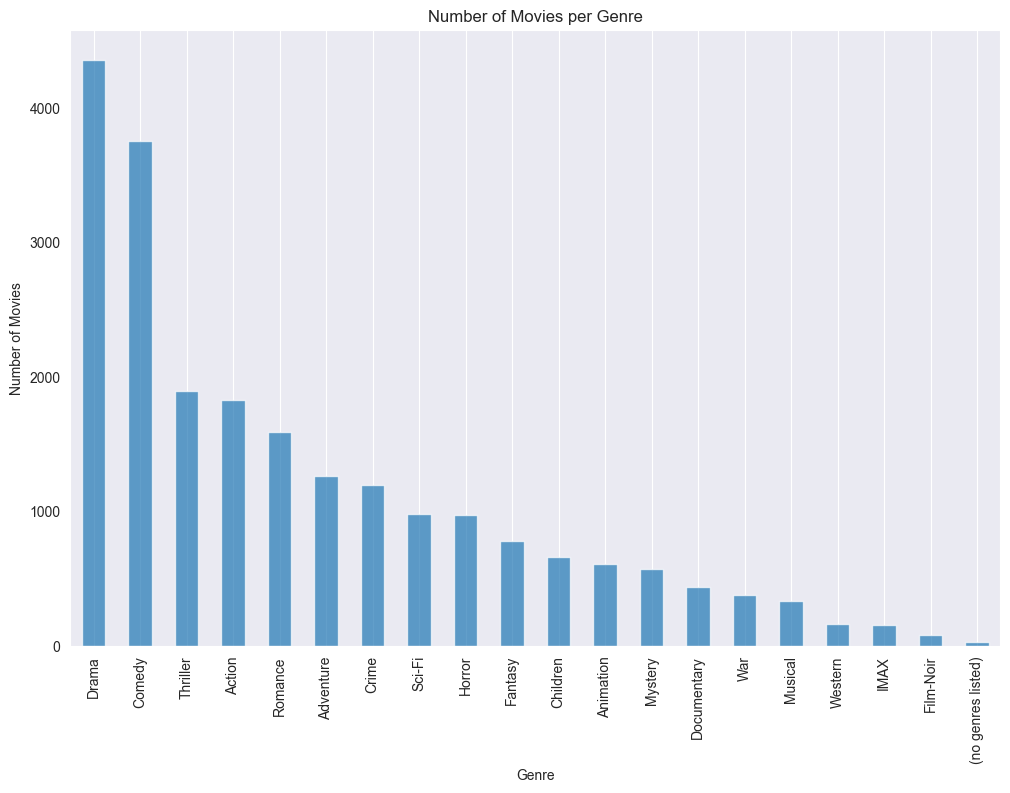

In [8]:
# Cell 6: Vẽ biểu đồ phân phối thể loại phim
def plot_genre_distribution():
    movies_df['Year'] = movies_df['Title'].apply(extract_year)  # Trích xuất năm từ tiêu đề
    genre_counts = movies_df['Genre'].str.split('|').explode().value_counts()
    plt.figure(figsize=(12, 8))
    genre_counts.plot(kind='bar', alpha=0.7)
    plt.xlabel('Genre')
    plt.ylabel('Number of Movies')
    plt.title('Number of Movies per Genre')
    plt.grid(axis='y')
    plt.show()  # Hiển thị biểu đồ trên Jupyter Notebook

# Vẽ biểu đồ phân phối thể loại
plot_genre_distribution()


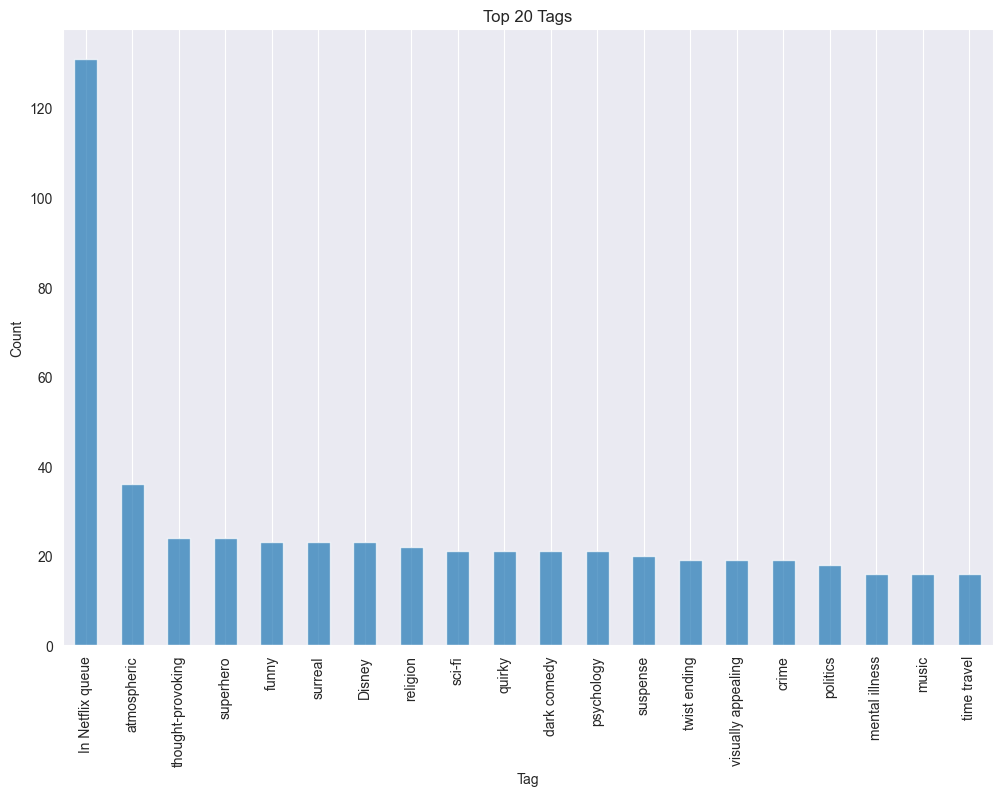

In [9]:
# Cell 7: Vẽ biểu đồ phân phối tag
def plot_tag_distribution():
    tag_counts = tags_df['Tag'].value_counts().head(20)  # Top 20 tags
    plt.figure(figsize=(12, 8))
    tag_counts.plot(kind='bar', alpha=0.7)
    plt.xlabel('Tag')
    plt.ylabel('Count')
    plt.title('Top 20 Tags')
    plt.grid(axis='y')
    plt.show()  # Hiển thị biểu đồ trên Jupyter Notebook

# Vẽ biểu đồ phân phối tag
plot_tag_distribution()


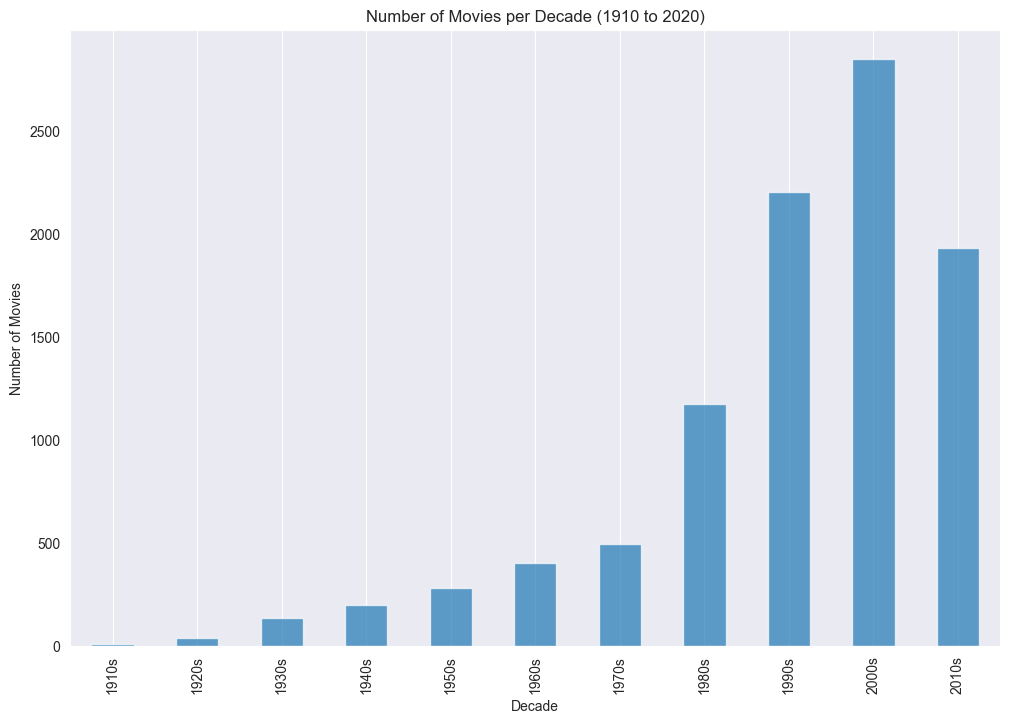

In [10]:
# Cell 8: Vẽ biểu đồ số lượng phim theo chu kỳ 10 năm
def plot_decade_distribution():
    movies_df['Year'] = movies_df['Title'].apply(extract_year)  # Trích xuất năm từ tiêu đề
    movies_df['Decade'] = (movies_df['Year'] // 10) * 10  # Nhóm theo khoảng 10 năm
    decade_counts = movies_df['Decade'].value_counts().sort_index()
    decade_counts = decade_counts[(decade_counts > 0) & (decade_counts.index >= 1910) & (decade_counts.index <= 2020)]

    decade_labels = [f"{int(decade)}s" for decade in decade_counts.index]
    decade_counts.index = decade_labels

    plt.figure(figsize=(12, 8))
    decade_counts.plot(kind='bar', alpha=0.7)
    plt.xlabel('Decade')
    plt.ylabel('Number of Movies')
    plt.title('Number of Movies per Decade (1910 to 2020)')
    plt.grid(axis='y')
    plt.show()  # Hiển thị biểu đồ trên Jupyter Notebook

# Vẽ biểu đồ số lượng phim theo thập kỷ
plot_decade_distribution()


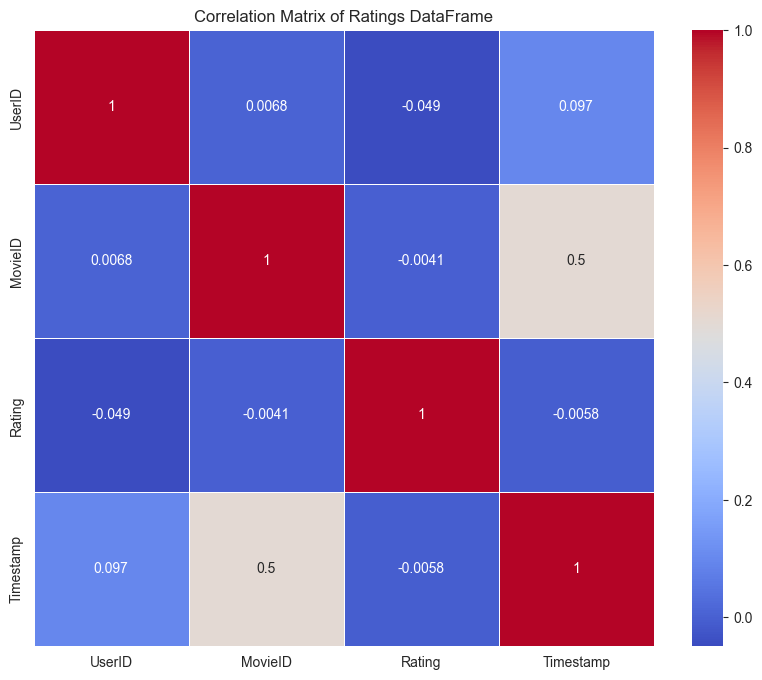

In [11]:
# Cell 9: Vẽ ma trận tương quan chỉ số trên các cột của ratings_df
import seaborn as sns
import matplotlib.pyplot as plt
# Tính toán ma trận tương quan cho ratings_df
correlation_matrix = ratings_df.corr()

# Vẽ ma trận tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Ratings DataFrame')
plt.show()
